# FINAL PROJECT: MNIST handwritten digit images to train a MLP  
### Group 5: Shambhavi Danayak, Kimaya D Sawant, Pradnya R Ghadge, 

#  1. Import Libraries

We first import all necessary libraries including PyTorch, torchvision for datasets and transforms, and matplotlib/numpy for visualization.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import random

## TASK 2: 
a helper function that can read all image files (following filename convention defined in Task1) into a Numpy array, and assign the corresponding labels in another Numpy array.  
- load ".png" handwritten data
- extract label
- verify shape
- return images and labels

In [3]:
import os
from PIL import Image

In [4]:
def ProjectDataLoader(folder_path="C:/Users/kdsawant/Documents/csci 580/CSCI580_Spring25_Group5/FinalProject/HandWrittenData/digits"):
    image_list = [] #stores image pixels
    label_list = [] #corresponding digit labels

    for filename in os.listdir(folder_path):
        if filename.endswith(".png") and filename[0].isdigit():
            try:
                label = int(filename.split("-")[0])

                img_path = os.path.join(folder_path, filename)
                image = Image.open(img_path).convert("L")  # "L" = 8-bit pixels, black and white
                # Resize 
                image_array = np.array(image)

                if image_array.shape != (28, 28):
                    raise ValueError(f"Image {filename} is not 28x28 pixels")

                image_list.append(image_array)
                label_list.append(label)

            except Exception as e:
                print(f"Skipping {filename}: {e}")

    images = np.array(image_list, dtype=np.uint8)
    labels = np.array(label_list, dtype=np.int64)

    print(f"Loaded {len(images)} images and labels.")
    return images, labels


In [5]:
images, labels = ProjectDataLoader()
print("Shape of image set:", images.shape)
print("Sample label:", labels[0])

Loaded 330 images and labels.
Shape of image set: (330, 28, 28)
Sample label: 0


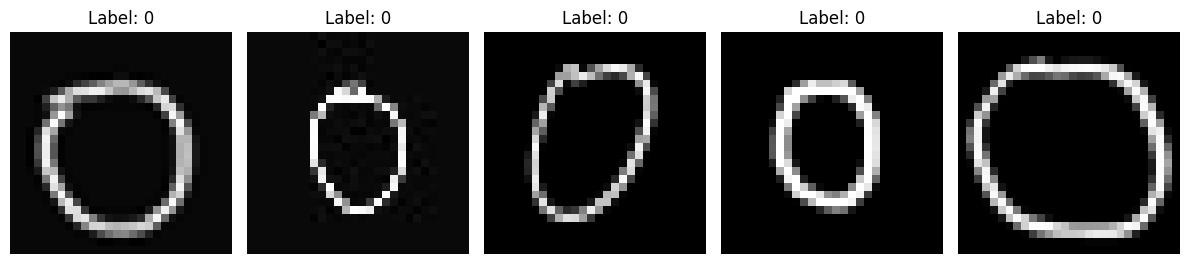

In [6]:
if images.shape[0] == 0:
    print("No images to display. Please check your image folder path and format.")
else:
    num_images = min(5, len(images))

    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))  
    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


## Task 3: Preprocess image data using Pytorch

In [7]:
def preprocess_images(images_np):
    preprocess = transforms.Compose([
        transforms.ToTensor(),                         
        transforms.Normalize((0.5,), (0.5,))           
    ])

    processed_images = []
    for i in range(images_np.shape[0]):
        img_tensor = preprocess(images_np[i])          
        processed_images.append(img_tensor)
    # Stack into a single tensor: shape → (N, 1, 28, 28)
    return torch.stack(processed_images)

images_tensor = preprocess_images(images)
labels_tensor = torch.tensor(labels, dtype=torch.long)  # shape: (330,)

from torch.utils.data import TensorDataset
local_dataset = TensorDataset(images_tensor, labels_tensor)


In [8]:
print("Processed image tensor shape:", images_tensor.shape)
print("Pixel range:", images_tensor.min().item(), "to", images_tensor.max().item())

Processed image tensor shape: torch.Size([330, 1, 28, 28])
Pixel range: -1.0 to 1.0


In [9]:
os.makedirs("SavedData", exist_ok=True)
torch.save(images_tensor, "SavedData/images_tensor.pt")
torch.save(labels_tensor, "SavedData/labels_tensor.pt")

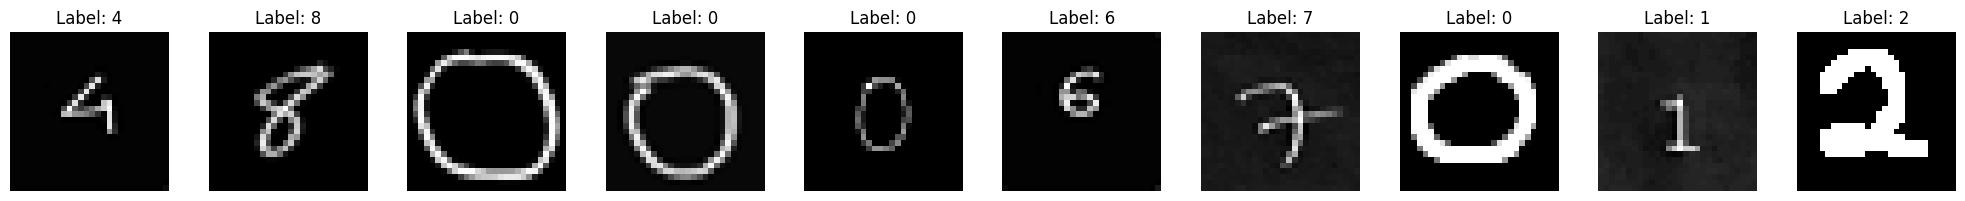

In [10]:
images_tensor = torch.load("SavedData/images_tensor.pt")
labels_tensor = torch.load("SavedData/labels_tensor.pt")
def show_random_images(images_tensor, labels_tensor, n=10):
    indices = random.sample(range(len(images_tensor)), n)
    plt.figure(figsize=(n * 2, 2))
    for i, idx in enumerate(indices):
        image = images_tensor[idx].squeeze().numpy()
        label = labels_tensor[idx].item()

        plt.subplot(1, n, i + 1)
        plt.imshow(image, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Usage:
show_random_images(images_tensor, labels_tensor, n=10)

### load MNIST dataset

In [11]:
# doing this again as MNIST DATASET is not in the form of NumPy array
from torch.utils.data import Subset, ConcatDataset, DataLoader
from torchvision import datasets



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Fix: sample the same number of MNIST images as local ones (330)
mnist_indices = random.sample(range(len(mnist_full)), len(images_tensor))  # random 330
mnist_train_subset = Subset(mnist_full, mnist_indices)
mnist_val_subset = Subset(mnist_full, list(range(50000, 60000)))    # 50k–60k



In [12]:
# Convert MNIST labels from int to tensor using wrapper
class TensorWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        return x, torch.tensor(y, dtype=torch.long)  # Convert int → tensor


In [13]:
mnist_train_subset = TensorWrapper(mnist_train_subset)


## Combine the Two Datasets

In [14]:

combined_dataset = ConcatDataset([mnist_train_subset, local_dataset])


### Create dataloader for the training

In [15]:

train_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(mnist_val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)


### visualize  loaded data (Train= Learn, Val= Tune, Test= Prove)

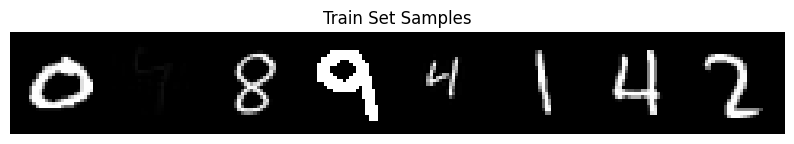

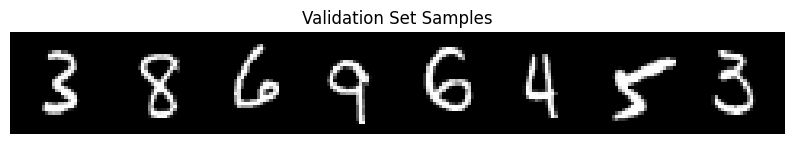

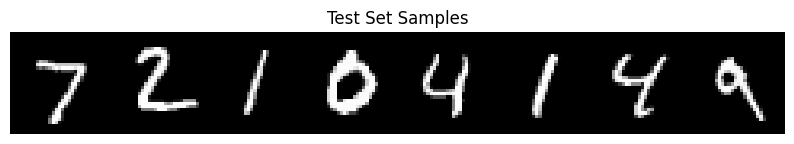

In [17]:
def show_batch(loader, title="Sample Images from DataLoader"):
    images, labels = next(iter(loader))  
    img_grid = torchvision.utils.make_grid(images[:8], nrow=8, padding=2, normalize=True)

    plt.figure(figsize=(10, 2))
    plt.imshow(img_grid.permute(1, 2, 0))  
    plt.title(title)
    plt.axis("off")
    plt.show()

show_batch(train_loader, title="Train Set Samples")
show_batch(val_loader, title="Validation Set Samples")
show_batch(test_loader, title="Test Set Samples")

### MLP Architecture (2 hidden, 1 input , 1 output layer), with ReLU, loss function CrossEntropyLoss, lr=0.001 and 10 rpochs

In [20]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),                  
            nn.Linear(784, 256), #hidden layer 1
            nn.ReLU(),
            nn.Linear(256, 128), #hidden layer 2
            nn.ReLU(),
            nn.Linear(128, 10) #output layer 10 neurons since we have classes           
        )

    def forward(self, x):
        return self.model(x)

model = MLP()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_acc:.2f}%")

#save model
os.makedirs("SavedModels", exist_ok=True)
torch.save(model.state_dict(), "SavedModels/mlp_mnist_state_dict.pth")
torch.save(model, "SavedModels/mlp_mnist_full_model.pth")
print("Model saved successfully!")

Epoch [1/10] Train Loss: 2.2398 | Train Acc: 20.76% | Val Loss: 2.0105 | Val Acc: 37.62%
Epoch [2/10] Train Loss: 1.9836 | Train Acc: 33.79% | Val Loss: 1.5432 | Val Acc: 58.43%
Epoch [3/10] Train Loss: 1.7129 | Train Acc: 42.42% | Val Loss: 1.2289 | Val Acc: 56.59%
Epoch [4/10] Train Loss: 1.5301 | Train Acc: 46.52% | Val Loss: 1.0554 | Val Acc: 66.37%
Epoch [5/10] Train Loss: 1.4514 | Train Acc: 51.36% | Val Loss: 0.8554 | Val Acc: 75.11%
Epoch [6/10] Train Loss: 1.2694 | Train Acc: 58.94% | Val Loss: 0.7893 | Val Acc: 76.96%
Epoch [7/10] Train Loss: 1.1842 | Train Acc: 61.82% | Val Loss: 0.6938 | Val Acc: 77.05%
Epoch [8/10] Train Loss: 1.1075 | Train Acc: 63.94% | Val Loss: 0.6185 | Val Acc: 81.85%
Epoch [9/10] Train Loss: 1.0407 | Train Acc: 65.76% | Val Loss: 0.6451 | Val Acc: 79.78%
Epoch [10/10] Train Loss: 1.0164 | Train Acc: 68.03% | Val Loss: 0.6227 | Val Acc: 80.65%
Model saved successfully!


In [72]:
## test accuracy (prove) on MNIST DATA
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Test Accuracy on MNIST: {100 * correct / total:.2f}%")

Final Test Accuracy on MNIST: 45.54%


# Test Trained MLP on Handwritten Dataset 

In [75]:
# Load your handwritten test data
images_tensor = torch.load("SavedData/images_tensor.pt")
labels_tensor = torch.load("SavedData/labels_tensor.pt")

# Make sure to move tensors to same device as model
images_tensor = images_tensor.to(device)
labels_tensor = labels_tensor.to(device)


In [76]:
model.eval()
correct = 0
total = labels_tensor.size(0)

with torch.no_grad():
    outputs = model(images_tensor)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels_tensor).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on Handwritten Digits: {accuracy:.2f}%")

Accuracy on Handwritten Digits: 54.24%


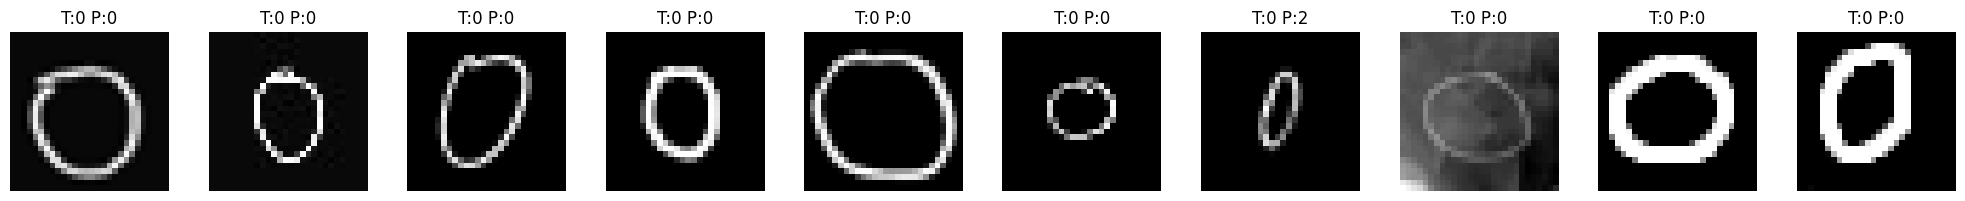

In [77]:
## plot the resulting handwritten data on the saved mode;l
import matplotlib.pyplot as plt

def show_predictions(images, labels, preds, n=10):
    plt.figure(figsize=(n*2, 2))
    for i in range(n):
        img = images[i].cpu().squeeze().numpy()
        true = labels[i].item()
        pred = preds[i].item()
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"T:{true} P:{pred}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Show predictions
show_predictions(images_tensor, labels_tensor, predicted, n=10)

In [78]:
# Evaluation on MNIST test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on MNIST test images: {100 * correct / total:.2f}%')


Accuracy on MNIST test images: 45.54%


In [26]:
# Evaluation on group-collected digit images
model.eval()
images_tensor = images_tensor.to(device)
labels_tensor = labels_tensor.to(device)
with torch.no_grad():
    outputs = model(images_tensor)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels_tensor).sum().item()
    total = labels_tensor.size(0)
    accuracy = 100 * correct / total
print("Predictions:", predicted.cpu().numpy())
print("Ground Truth:", labels_tensor.cpu().numpy())
print(f"Accuracy on Group Digits: {accuracy:.2f}%")


Predictions: [0 0 0 0 0 7 6 0 0 0 0 0 5 7 7 8 0 0 0 7 0 0 0 0 0 0 0 0 0 6 7 0 0 1 1 1 1
 1 1 1 5 1 1 1 6 1 0 1 1 1 3 2 8 2 0 0 0 1 2 1 0 1 6 1 1 1 1 1 2 2 2 2 6 9
 2 7 2 0 5 5 3 5 3 8 7 6 2 0 0 0 6 2 2 2 6 6 6 2 2 3 5 2 8 3 6 7 8 3 1 3 3
 0 7 7 7 8 7 2 7 0 0 0 0 7 2 5 3 2 1 1 7 3 7 4 4 4 4 7 4 9 4 4 4 4 5 7 5 4
 1 7 4 5 7 0 0 0 7 1 4 0 7 4 8 4 4 5 8 6 6 5 7 6 6 5 5 5 6 7 0 7 3 7 7 0 8
 0 0 0 0 5 0 7 5 5 8 7 0 5 6 6 6 6 6 6 6 7 6 6 6 2 4 8 7 4 6 4 0 6 0 0 0 0
 6 2 0 6 6 1 6 6 6 0 6 2 2 7 7 7 6 7 7 7 7 7 7 7 7 3 7 2 1 0 0 0 0 7 7 7 7
 7 8 7 7 7 2 8 8 8 8 8 8 6 8 8 8 8 7 7 8 8 3 3 2 3 0 0 0 0 8 8 0 8 8 8 9 8
 3 9 9 9 9 9 9 5 8 9 9 9 7 8 7 7 7 7 7 7 3 0 0 0 0 4 7 7 9 6 1 7 9 9]
Ground Truth: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 

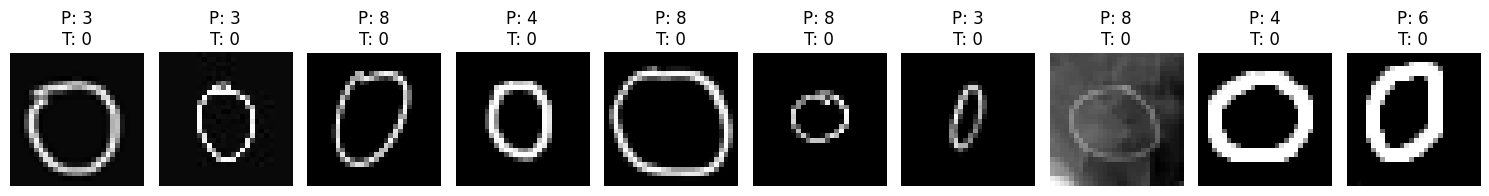

In [79]:
# Visualization of predictions
images_cpu = images_tensor.cpu()
predicted_cpu = predicted.cpu()
labels_cpu = labels_tensor.cpu()
N = min(10, len(images_cpu))
plt.figure(figsize=(15, 3))
for i in range(N):
    plt.subplot(1, N, i + 1)
    plt.imshow(images_cpu[i].squeeze(), cmap='gray')
    plt.title(f"P: {predicted_cpu[i].item()}\nT: {labels_cpu[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## Manual Hyperparameter Tuning

In [82]:
import torch.nn as nn
import torch.optim as optim

class MLP_Tuned(nn.Module):
    def __init__(self):
        super(MLP_Tuned, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(torch.relu(self.fc2(x)))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate model and move to device
model = MLP_Tuned().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Add learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop with scheduler
epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()  # update LR
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

Epoch [1/20] Loss: 2.3073 | LR: 0.000500
Epoch [2/20] Loss: 2.2930 | LR: 0.000500
Epoch [3/20] Loss: 2.3070 | LR: 0.000500
Epoch [4/20] Loss: 2.3065 | LR: 0.000500
Epoch [5/20] Loss: 2.2898 | LR: 0.000250
Epoch [6/20] Loss: 2.2762 | LR: 0.000250
Epoch [7/20] Loss: 2.2812 | LR: 0.000250
Epoch [8/20] Loss: 2.2802 | LR: 0.000250
Epoch [9/20] Loss: 2.2664 | LR: 0.000250
Epoch [10/20] Loss: 2.2357 | LR: 0.000125
Epoch [11/20] Loss: 2.2430 | LR: 0.000125
Epoch [12/20] Loss: 2.2487 | LR: 0.000125
Epoch [13/20] Loss: 2.1932 | LR: 0.000125
Epoch [14/20] Loss: 2.2041 | LR: 0.000125
Epoch [15/20] Loss: 2.1876 | LR: 0.000063
Epoch [16/20] Loss: 2.1866 | LR: 0.000063
Epoch [17/20] Loss: 2.2139 | LR: 0.000063
Epoch [18/20] Loss: 2.1897 | LR: 0.000063
Epoch [19/20] Loss: 2.2130 | LR: 0.000063
Epoch [20/20] Loss: 2.1556 | LR: 0.000031


In [83]:
    # Evaluate on training data
    model.eval()
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    # Evaluate on validation data
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    print(f"Train Accuracy: {train_accuracy:.2f}% | Validation Accuracy: {val_accuracy:.2f}%")


Train Accuracy: 37.12% | Validation Accuracy: 19.70%


In [84]:
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()

    # Accuracy reporting
    model.eval()
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")
    print(f"Train Accuracy: {train_accuracy:.2f}% | Validation Accuracy: {val_accuracy:.2f}%\\n")


Epoch [1/20] Loss: 2.1527 | LR: 0.000031
Train Accuracy: 34.47% | Validation Accuracy: 18.18%\n
Epoch [2/20] Loss: 2.1892 | LR: 0.000031
Train Accuracy: 32.95% | Validation Accuracy: 18.18%\n
Epoch [3/20] Loss: 2.1517 | LR: 0.000031
Train Accuracy: 31.82% | Validation Accuracy: 16.67%\n
Epoch [4/20] Loss: 2.1445 | LR: 0.000031
Train Accuracy: 33.33% | Validation Accuracy: 13.64%\n
Epoch [5/20] Loss: 2.1626 | LR: 0.000016
Train Accuracy: 33.71% | Validation Accuracy: 13.64%\n
Epoch [6/20] Loss: 2.1683 | LR: 0.000016
Train Accuracy: 34.47% | Validation Accuracy: 15.15%\n
Epoch [7/20] Loss: 2.1617 | LR: 0.000016
Train Accuracy: 32.58% | Validation Accuracy: 15.15%\n
Epoch [8/20] Loss: 2.1629 | LR: 0.000016
Train Accuracy: 31.82% | Validation Accuracy: 15.15%\n
Epoch [9/20] Loss: 2.1648 | LR: 0.000016
Train Accuracy: 31.82% | Validation Accuracy: 16.67%\n
Epoch [10/20] Loss: 2.1654 | LR: 0.000008
Train Accuracy: 31.82% | Validation Accuracy: 18.18%\n
Epoch [11/20] Loss: 2.1636 | LR: 0.0000

In [85]:
# Evaluation on MNIST test dataset
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f" Accuracy on MNIST test images: {test_accuracy:.2f}%")


 Accuracy on MNIST test images: 34.11%


In [86]:
# Evaluation on group-collected digit images
model.eval()
images_tensor = images_tensor.to(device)
labels_tensor = labels_tensor.to(device)

with torch.no_grad():
    outputs = model(images_tensor)
    _, predicted = torch.max(outputs, 1)
    correct_group = (predicted == labels_tensor).sum().item()
    total_group = labels_tensor.size(0)

group_accuracy = 100 * correct_group / total_group

# print(f" Predictions: {predicted.cpu().numpy()}")
# print(f"Ground Truth: {labels_tensor.cpu().numpy()}")
print(f"Accuracy on Group-Collected Digits: {group_accuracy:.2f}%")


Accuracy on Group-Collected Digits: 29.39%


## Grid Search

In [87]:
import itertools

# Flexible MLP class for grid search
class MLP_Tuned_GridSearch(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, dropout_rate):
        super(MLP_Tuned_GridSearch, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden2, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x


In [88]:
# Grid of hyperparameters

param_grid = {
    'lr': [0.001, 0.0005, 0.0003],         
    'hidden1': [512, 640],             
    'hidden2': [256, 192],           
    'dropout': [0.2, 0.25],           
    'epochs': [15, 20]                    
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
param_combinations = list(itertools.product(*param_grid.values()))

val_split = int(len(images_tensor) * 0.2)
train_split = len(images_tensor) - val_split
train_dataset, val_dataset = random_split(TensorDataset(images_tensor, labels_tensor), [train_split, val_split])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

best_accuracy = 0
best_params = None






In [89]:
for params in param_combinations:
    lr, h1, h2, dropout, num_epochs = params
    print(f"\nTrying: lr={lr}, hidden1={h1}, hidden2={h2}, dropout={dropout}, epochs={num_epochs}")

    model = MLP_Tuned_GridSearch(28*28, h1, h2, dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Train
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f" Validation Accuracy: {accuracy:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print("\n Best Validation Accuracy: {:.2f}% with parameters:".format(best_accuracy))
print(f"   lr={best_params[0]}, hidden1={best_params[1]}, hidden2={best_params[2]}, dropout={best_params[3]}, epochs={best_params[4]}")



Trying: lr=0.001, hidden1=512, hidden2=256, dropout=0.2, epochs=15
 Validation Accuracy: 27.27%

Trying: lr=0.001, hidden1=512, hidden2=256, dropout=0.2, epochs=20
 Validation Accuracy: 39.39%

Trying: lr=0.001, hidden1=512, hidden2=256, dropout=0.25, epochs=15
 Validation Accuracy: 24.24%

Trying: lr=0.001, hidden1=512, hidden2=256, dropout=0.25, epochs=20
 Validation Accuracy: 21.21%

Trying: lr=0.001, hidden1=512, hidden2=192, dropout=0.2, epochs=15
 Validation Accuracy: 19.70%

Trying: lr=0.001, hidden1=512, hidden2=192, dropout=0.2, epochs=20
 Validation Accuracy: 25.76%

Trying: lr=0.001, hidden1=512, hidden2=192, dropout=0.25, epochs=15
 Validation Accuracy: 19.70%

Trying: lr=0.001, hidden1=512, hidden2=192, dropout=0.25, epochs=20
 Validation Accuracy: 22.73%

Trying: lr=0.001, hidden1=640, hidden2=256, dropout=0.2, epochs=15
 Validation Accuracy: 10.61%

Trying: lr=0.001, hidden1=640, hidden2=256, dropout=0.2, epochs=20
 Validation Accuracy: 12.12%

Trying: lr=0.001, hidden1